## Imports
---

In [1]:
import sys
from functools import partial
from pathlib import Path
from typing import Callable

import einops
import numpy as np
import skimage
import torch
import torchvision.transforms.functional as tvtf
import torchvision.utils as tvu
from kornia.feature import DenseSIFTDescriptor, SIFTDescriptor
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from tqdm import tqdm

sys.path.insert(0, "..")
import rihog

## Dataset
---

In [2]:
DS_PATH = Path("../Original Brodatz")
IMG_SIZE = 128
#DEVICE = torch.device("cpu")
DEVICE = torch.device("cuda")

In [3]:
def get_img_id(fpath: Path):
	return int(fpath.stem[1:])
img_tnsr_list = []
img_lbl_list = []
img_fpath_list = sorted(DS_PATH.iterdir(), key=get_img_id)
N_IMG = len(img_fpath_list)
for img_fpath in tqdm(img_fpath_list):
	img = Image.open(img_fpath)
	lbl = get_img_id(img_fpath)
	for angle in range(0, 360, 30):
		rot_img = img.rotate(angle=angle, resample=Image.Resampling.BICUBIC)
		rot_img_tnsr = tvtf.to_tensor(rot_img)
		crop_rot_img_tnsr = tvtf.center_crop(rot_img_tnsr, IMG_SIZE)
		img_tnsr_list.append(crop_rot_img_tnsr)
		img_lbl_list.append(lbl)
N_IMG = len(img_fpath_list)
N_ROT = len(img_tnsr_list) // N_IMG
data_imgs = torch.stack(img_tnsr_list).to(DEVICE)
data_img_bs = einops.rearrange(data_imgs, "(i r) 1 h w -> i r 1 h w", i=N_IMG, r=N_ROT)
data_lbls = torch.tensor(img_lbl_list, dtype=torch.int)
data_lbl_bs = einops.rearrange(data_lbls, "(i r) -> i r", i=N_IMG, r=N_ROT)
data_img_bs.shape, data_lbl_bs.shape

100%|██████████| 112/112 [00:06<00:00, 16.38it/s]


(torch.Size([112, 12, 1, 128, 128]), torch.Size([112, 12]))

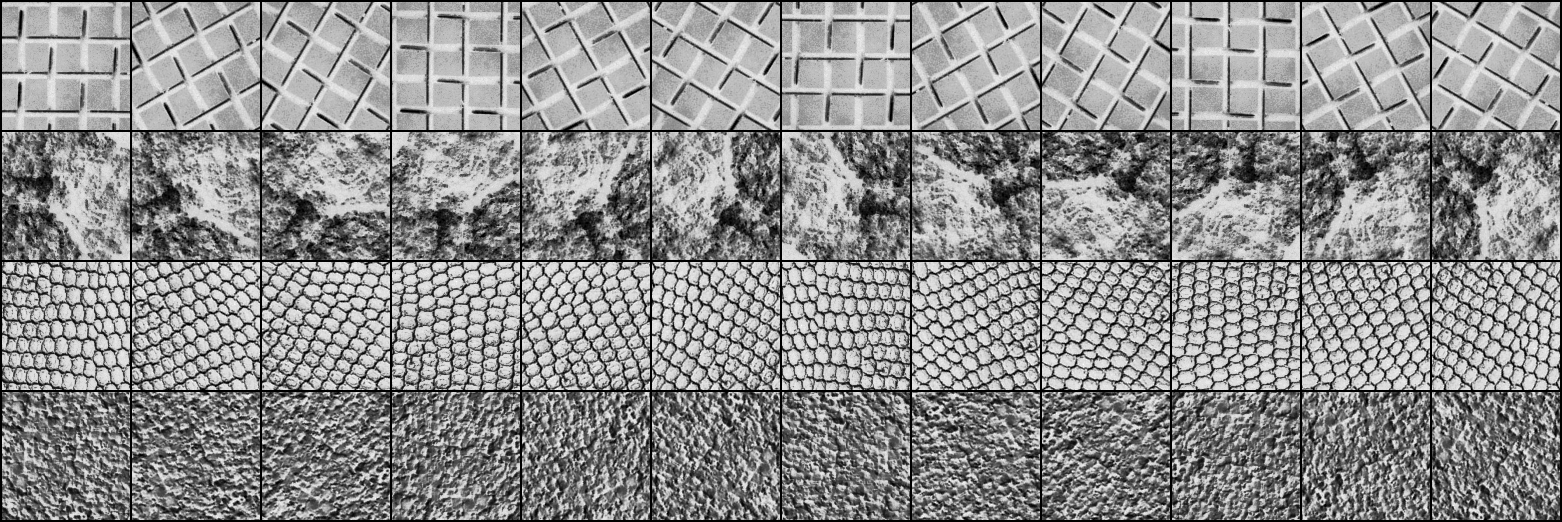

In [4]:
tvtf.to_pil_image(tvu.make_grid(data_img_bs[:4].reshape(-1, 1, IMG_SIZE, IMG_SIZE), nrow=N_ROT))

## Data split
---

In [5]:
#N_TRAIN = 7
N_TRAIN = 2

In [6]:
train_lbl_bs, test_lbl_bs = data_lbl_bs[:, :N_TRAIN], data_lbl_bs[:, N_TRAIN:]
train_lbl_bs.shape, test_lbl_bs.shape

(torch.Size([112, 2]), torch.Size([112, 10]))

In [7]:
train_img_bs, test_img_bs = data_img_bs[:, :N_TRAIN], data_img_bs[:, N_TRAIN:]
train_img_bs.shape, test_img_bs.shape

(torch.Size([112, 2, 1, 128, 128]), torch.Size([112, 10, 1, 128, 128]))

## RIHOG
---

In [8]:
#rihog_fextr = rihog.RIHOG(nbhd_steps=4, num_bins=8)
#rihog_fextr = rihog.RIHOG(nbhd_steps=4, num_bins=8, nbhd_mode=rihog.NeighborhoodMode.CIRCLE)
rihog_fextr = rihog.RIHOG(nbhd_steps=4, num_bins=8, rel_magn_mode=rihog.RelativeMagnitudeMode.RATIO)
rihog_fextr

RIHOG(
    nbhd_steps=4,
    num_bins=8,
    nbhd_mode='square',
    rel_magn_mode='ratio'
)

### kNN

#### all features

In [9]:
def compute_rihog_all(extr: rihog.RIHOG, img_bs: torch.Tensor):
	img_rihog_list = []
	for img_b in img_bs:
		for img in img_b:
			img_rihog = extr(img.unsqueeze(0))
			img_rihog_list.append(torch.from_numpy(KMeans().fit(img_rihog[0].cpu()).cluster_centers_).unsqueeze(0))  # subset to avoid OOM
	rihog = torch.cat(img_rihog_list, dim=0)
	return rihog

In [10]:
train_rihog = compute_rihog_all(rihog_fextr, train_img_bs)
train_rihog.shape

torch.Size([224, 8, 32])

In [11]:
test_rihog = compute_rihog_all(rihog_fextr, test_img_bs)
test_rihog.shape

torch.Size([1120, 8, 32])

In [12]:
exp_flat_train_lbl = train_lbl_bs.reshape(-1, 1).expand((-1, train_rihog.shape[1]))
exp_flat_train_lbl.shape

torch.Size([224, 8])

In [13]:
exp_flat_test_lbl = test_lbl_bs.reshape(-1, 1).expand((-1, test_rihog.shape[1]))
exp_flat_test_lbl.shape

torch.Size([1120, 8])

In [14]:
knn = KNeighborsClassifier(weights="distance", metric="cosine").fit(train_rihog.reshape(-1, 32).cpu(), exp_flat_train_lbl.reshape(-1))
knn.score(test_rihog.reshape(-1, 32).cpu(), exp_flat_test_lbl.reshape(-1))

0.478125

#### avg feature

In [15]:
def compute_rihog_avg(fextr: rihog.RIHOG, img_bs: torch.Tensor):
	avg_rihog_b_list = []
	for img_b in img_bs:
		rihog_b = fextr(img_b)  # (b wc f)
		avg_rihog_b = rihog_b.mean(dim=1)  # (b f)
		avg_rihog_b_list.append(avg_rihog_b)
	rihog_feats = torch.cat(avg_rihog_b_list, dim=0).numpy(force=True)
	return rihog_feats

In [16]:
rihog_train_feats = compute_rihog_avg(rihog_fextr, train_img_bs)
rihog_train_feats.shape

(224, 32)

In [17]:
rihog_test_feats = compute_rihog_avg(rihog_fextr, test_img_bs)
rihog_test_feats.shape

(1120, 32)

In [18]:
knn = KNeighborsClassifier(weights="distance", metric="cosine").fit(rihog_train_feats, train_lbl_bs.ravel())
knn.score(rihog_test_feats, test_lbl_bs.ravel())

0.9785714285714285

### GMM+SVM

In [19]:
train_rihog_feat_list = list(np.expand_dims(rihog_train_feats, axis=1))
test_rihog_feat_list = list(np.expand_dims(rihog_test_feats, axis=1))
print(len(train_rihog_feat_list))
print(train_rihog_feat_list[0].shape)

224
(1, 32)


In [20]:
train_rihog_gmm = skimage.feature.learn_gmm(train_rihog_feat_list, n_modes=8)
train_rihog_fvs = np.array([skimage.feature.fisher_vector(train_img_rihog, train_rihog_gmm) for train_img_rihog in train_rihog_feat_list])
train_rihog_fvs.shape

(224, 520)

In [21]:
rihog_svm = LinearSVC().fit(train_rihog_fvs, train_lbl_bs.ravel().numpy())

/home/dnanni/miniconda3/envs/rihog/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [22]:
test_rihog_fvs = np.array([skimage.feature.fisher_vector(test_img_rihog, train_rihog_gmm) for test_img_rihog in test_rihog_feat_list])
rihog_svm.score(test_rihog_fvs, test_lbl_bs.ravel().numpy())

0.9419642857142857

## HOG
---

In [23]:
def compute_hog_avg(fextr: Callable[[np.ndarray], np.ndarray], img_bs: torch.Tensor):
	img_avg_hog_list = []
	for img_b in img_bs.numpy(force=True):
		for img in img_b:
			img_hog = fextr(img[0])  # (vb hb vc hc f)
			img_avg_hog = img_hog.mean(axis=(0, 1, 2, 3))  # (f)
			img_avg_hog_list.append(img_avg_hog)
	hog_feats = np.array(img_avg_hog_list)
	return hog_feats

In [24]:
#hog_fextr = partial(skimage.feature.hog, feature_vector=False, orientations=8, pixels_per_cell=(8, 8))
hog_fextr = partial(skimage.feature.hog, feature_vector=False, orientations=32, pixels_per_cell=(8, 8))

In [25]:
train_hog_feats = compute_hog_avg(hog_fextr, train_img_bs)
train_hog_feats.shape

(224, 32)

In [26]:
test_hog_feats = compute_hog_avg(hog_fextr, test_img_bs)
test_hog_feats.shape

(1120, 32)

In [27]:
knn = KNeighborsClassifier(weights="distance", metric="cosine").fit(train_hog_feats, train_lbl_bs.ravel())
knn.score(test_hog_feats, test_lbl_bs.ravel())

0.2625

## SIFT
---

In [28]:
#sift_cls = partial(skimage.feature.SIFT, upsampling=1)

In [29]:
sift_fextr = skimage.feature.SIFT(upsampling=1)

### kNN

#### all features

In [30]:
def compute_sift_all(fextr: skimage.feature.SIFT, img_bs: torch.Tensor, lbl_bs: torch.Tensor):
	img_sift_list = []
	lbl_list = []
	count = 0
	for img_b, lbl_b in zip(img_bs.numpy(force=True), lbl_bs.numpy(force=True)):
		for img, lbl in zip(img_b, lbl_b):
			try:
				fextr.detect_and_extract(img[0])
			except RuntimeError:
				pass
			else:
				img_sift = fextr.descriptors  # (n f)
				img_sift_list.append(img_sift)
				lbl_list.append([lbl] * len(img_sift))
				count += 1
	sift_feats = np.concat(img_sift_list)
	lbls = np.concat(lbl_list)
	return sift_feats, lbls, count

In [31]:
train_sift_feats, train_sift_lbls, train_sift_count = compute_sift_all(sift_fextr, train_img_bs, train_lbl_bs)
test_sift_feats, test_sift_lbls, test_sift_count = compute_sift_all(sift_fextr, test_img_bs, test_lbl_bs)
train_sift_feats.shape, train_sift_lbls.shape, train_sift_count

((15819, 128), (15819,), 218)

In [32]:
test_sift_count, test_lbl_bs.nelement()

(1085, 1120)

In [33]:
#knn = KNeighborsClassifier(weights="distance", metric="cosine").fit(train_sift_feats, train_sift_lbls)
knn = KNeighborsClassifier(weights="distance", metric="cosine").fit(train_sift_feats, train_sift_lbls)
sift_knn_score = knn.score(test_sift_feats, test_sift_lbls) * test_sift_count / test_lbl_bs.numel()
sift_knn_score

0.8838371956706336

#### avg feature

In [34]:
def compute_sift_avg(fextr: skimage.feature.SIFT, img_bs: torch.Tensor, lbl_bs: torch.Tensor):
	img_avg_sift_list = []
	lbl_list = []
	for img_b, lbl_b in zip(img_bs.numpy(force=True), lbl_bs.numpy(force=True)):
		for img, lbl in zip(img_b, lbl_b):
			try:
				fextr.detect_and_extract(img[0])
			except RuntimeError:
				pass
			else:
				img_sift = fextr.descriptors  # (n f)
				img_avg_sift = img_sift.mean(axis=0)
				img_avg_sift_list.append(img_avg_sift)
				lbl_list.append(lbl)
	sift_feats = np.array(img_avg_sift_list)
	lbls = np.array(lbl_list)
	return sift_feats, lbls

In [35]:
train_sift_feats, train_sift_lbls = compute_sift_avg(sift_fextr, train_img_bs, train_lbl_bs)
test_sift_feats, test_sift_lbls = compute_sift_avg(sift_fextr, test_img_bs, test_lbl_bs)
train_sift_feats.shape, train_sift_lbls.shape, test_sift_feats.shape, test_sift_lbls.shape

((218, 128), (218,), (1085, 128), (1085,))

In [36]:
test_lbl_bs.numel()

1120

In [37]:
knn = KNeighborsClassifier(weights="distance", metric="cosine").fit(train_sift_feats, train_sift_lbls)
sift_knn_score = knn.score(test_sift_feats, test_sift_lbls) * len(test_sift_lbls) / test_lbl_bs.numel()
sift_knn_score

0.9526785714285714

### GMM+SVM

In [38]:
def compute_sift_gmm(fextr: skimage.feature.SIFT, img_bs: torch.Tensor, lbl_bs: torch.Tensor):
	img_feats_list = []
	lbl_list = []
	for img_b, lbl_b in zip(img_bs.numpy(force=True), lbl_bs.numpy(force=True)):
		b_feats_list = []
		for img, lbl in zip(img_b, lbl_b):
			try:
				fextr.detect_and_extract(img[0])
			except RuntimeError:
				pass
			else:
				img_sift = fextr.descriptors  # (n f)
				b_feats_list.append(img_sift)
		if len(b_feats_list):
			img_feats = np.concat(b_feats_list)
			img_feats_list.append(img_feats)
			lbl_list.append(lbl)
	return img_feats_list, lbl_list

In [39]:
train_sift_feat_list, train_sift_lbl_list = compute_sift_gmm(sift_fextr, train_img_bs, train_lbl_bs)
test_sift_feat_list, test_sift_lbl_list = compute_sift_gmm(sift_fextr, test_img_bs, test_lbl_bs)

In [40]:
train_sift_gmm = skimage.feature.learn_gmm(train_sift_feat_list, n_modes=8)
train_sift_fvs = np.array([skimage.feature.fisher_vector(train_img_sift, train_sift_gmm) for train_img_sift in train_sift_feat_list])
sift_svm = LinearSVC().fit(train_sift_fvs, train_sift_lbl_list)

/home/dnanni/miniconda3/envs/rihog/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [41]:
test_sift_fvs = np.array([skimage.feature.fisher_vector(test_img_sift, train_sift_gmm) for test_img_sift in test_sift_feat_list])
sift_svm.score(test_sift_fvs, test_sift_lbl_list)

0.963302752293578

---

## SIFT (Kornia)

### Dense

In [42]:
ksift_fextr = DenseSIFTDescriptor(rootsift=False)
ksift_fextr

DenseSIFTDescriptor(num_ang_bins=8, num_spatial_bins=4, spatial_bin_size=4, rootsift=False, stride=1, clipval=0.2)

In [43]:
def compute_ksift(extr: DenseSIFTDescriptor, batches: torch.Tensor):
	with torch.no_grad():
		batch_avg_ksift_list = []
		for batch in batches:
			batch_ksift = extr(batch)
			batch_avg_ksift = batch_ksift.mean(dim=(-2, -1))
			batch_avg_ksift_list.append(batch_avg_ksift)
		avg_ksift = torch.cat(batch_avg_ksift_list, dim=0)
	return avg_ksift

In [44]:
train_ksift_feats = compute_ksift(ksift_fextr, train_img_bs)
train_ksift_feats.shape

torch.Size([224, 128])

In [45]:
test_ksift_feats = compute_ksift(ksift_fextr, test_img_bs)
test_ksift_feats.shape

torch.Size([1120, 128])

In [46]:
knn = KNeighborsClassifier(weights="distance", metric="cosine").fit(train_ksift_feats.cpu(), train_lbl_bs.ravel().numpy())
knn.score(test_ksift_feats.cpu(), test_lbl_bs.ravel().numpy())

0.16785714285714284

### Patch-wise

In [47]:
ksift_fextr = SIFTDescriptor(patch_size=IMG_SIZE, rootsift=False)
ksift_fextr

SIFTDescriptor(num_ang_bins=8, num_spatial_bins=4, patch_size=128, rootsift=False, clipval=0.2)

In [48]:
train_ksift_feats = ksift_fextr(einops.rearrange(train_img_bs, "i r c h w -> (i r) c h w"))
test_ksift_feats = ksift_fextr(einops.rearrange(test_img_bs, "i r c h w -> (i r) c h w"))

In [49]:
knn = KNeighborsClassifier(weights="distance", metric="cosine").fit(train_ksift_feats.numpy(force=True), train_lbl_bs.ravel().numpy())
knn.score(test_ksift_feats.numpy(force=True), test_lbl_bs.ravel().numpy())

0.05625